In [1]:
using RCall
using DataFrames, DataFramesMeta
using CSV
using DataVoyager
using Statistics
ENV["LINES"] = 10
ENV["COLUMNS"]=10000;

### Load Covid Data

source: https://covid.ourworldindata.org/data/owid-covid-data.csv

In [2]:
df = CSV.read("../data/owid-covid-data.csv",DataFrame)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
,String,String,String,Date…,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String?,Float64?,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,AFG,Asia,Afghanistan,2020-01-23,missing,0.0,missing,missing,0.0,missing,missing,0.0,missing,missing,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.0,3.89283e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-24,missing,0.0,missing,missing,0.0,missing,missing,0.0,missing,missing,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.0,3.89283e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-01-25,missing,0.0,missing,missing,0.0,missing,missing,0.0,missing,missing,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.0,3.89283e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-01-26,missing,0.0,missing,missing,0.0,missing,missing,0.0,missing,missing,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.0,3.89283e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.498
5,AFG,Asia,Afghanistan,2020-01-27,missing,0.0,missing,missing,0.0,missing,missing,0.0,missing,missing,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.0,3.89283e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.498
6,AFG,Asia,Afghanistan,2020-01-28,missing,0.0,0.0,missing,0.0,0.0,missing,0.0,0.0,missing,0.0,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.0,3.89283e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.498
7,AFG,Asia,Afghanistan,2020-01-29,missing,0.0,0.0,missing,0.0,0.0,missing,0.0,0.0,missing,0.0,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,0.0,3.89283e7,54.422,18.6,2.581,1.337,1803.99,missing,597.029,9.59,missing,missing,37.746,0.5,64.83,0.498
8,AFG,Asia,Afghanistan,2020-01-30,missing,0.0,0.0,missing,0.0,0.0,missing,0.0,0.0,missing,0.0,0.0,missing,missing,missi

### Modeling New Deaths

In [3]:
@rput df
R"""
library(tidyverse)
library(mice)

sdf = df %>% group_by(location) %>% 
summarise(
   mnewcases = mean(new_cases,na.rm=T),
   mnewdeaths = mean(new_deaths,na.rm=T),
   mpopulation = mean(population,na.rm=T),
   mcardio = mean(cardiovasc_death_rate,na.rm=T),
   mdiab = mean(diabetes_prevalence,na.rm=T),
   mhandwash = mean(handwashing_facilities,na.rm=T),
   mhbed = mean(hospital_beds_per_thousand,na.rm=T),
   mpatient = mean(hosp_patients,na.rm=T),
   madmission = mean(weekly_hosp_admissions,na.rm=T),
   mhdi = mean(human_development_index,na.rm=T),
   mle = mean(life_expectancy,na.rm=T)
) 
""" 

┌ Warning: RCall.jl: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
│ ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
│ ✔ tibble  3.0.4     ✔ dplyr   1.0.2
│ ✔ tidyr   1.1.2     ✔ stringr 1.4.0
│ ✔ readr   1.4.0     ✔ forcats 0.5.0
│ ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
│ ✖ dplyr::filter() masks stats::filter()
│ ✖ dplyr::lag()    masks stats::lag()
└ @ RCall /Users/ppalmes/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: 
│ Attaching package: ‘mice’
│ 
│ The following object is masked from ‘package:stats’:
│ 
│     filter
│ 
│ The following objects are masked from ‘package:base’:
│ 
│     cbind, rbind
│ 
└ @ RCall /Users/ppalmes/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: `summarise()` ungrouping output (override with `.groups` argument)
└ @ RCall /Users/ppalmes/.julia/packages/RCall/eRsxl/src/io.jl:160


RObject{VecSxp}
# A tibble: 190 x 12
   location mnewcases mnewdeaths mpopulation mcardio mdiab mhandwash  mhbed
   <chr>        <dbl>      <dbl>       <dbl>   <dbl> <dbl>     <dbl>  <dbl>
 1 Afghani…   149.        6.02      38928341    597.  9.59      37.7   0.5 
 2 Albania    150.        3.11       2877800    304. 10.1      NaN     2.89
 3 Algeria    283.        7.98      43851043    278.  6.73      83.7   1.9 
 4 Andorra     22.6       0.242        77265    109.  7.97     NaN   NaN   
 5 Angola      49.8       1.16      32866268    276.  3.94      26.7 NaN   
 6 Antigua…     0.459     0.0153       97928    192. 13.2      NaN     3.8 
 7 Argenti…  4597.      126.        45195777    191.  5.5      NaN     5   
 8 Armenia    455.        7.65       2963234    341.  7.11      94.0   4.2 
 9 Austral…    85.8       2.78      25499881    108.  5.07     NaN     3.84
10 Austria    994.       13.9        9006400    145.  6.35     NaN     7.37
# … with 180 more rows, and 4 more variables: mpati

In [4]:
dfimp = R"""
           imputed=mice(sdf,meth='sample')
           complete(imputed)
        """ |> rcopy


 iter imp variable
  1   1  mnewcases  mnewdeaths  mcardio  mdiab  mhandwash  mhbed  mpatient  madmission  mhdi  mle
  1   2  mnewcases  mnewdeaths  mcardio  mdiab  mhandwash  mhbed  mpatient  madmission  mhdi  mle
  1   3  mnewcases  mnewdeaths  mcardio  mdiab  mhandwash  mhbed  mpatient  madmission  mhdi  mle
  1   4  mnewcases  mnewdeaths  mcardio  mdiab  mhandwash  mhbed  mpatient  madmission  mhdi  mle
  1   5  mnewcases  mnewdeaths  mcardio  mdiab  mhandwash  mhbed  mpatient  madmission  mhdi  mle
  2   1  mnewcases  mnewdeaths  mcardio  mdiab  mhandwash  mhbed  mpatient  madmission  mhdi  mle
  2   2  mnewcases  mnewdeaths  mcardio  mdiab  mhandwash  mhbed  mpatient  madmission  mhdi  mle
  2   3  mnewcases  mnewdeaths  mcardio  mdiab  mhandwash  mhbed  mpatient  madmission  mhdi  mle
  2   4  mnewcases  mnewdeaths  mcardio  mdiab  mhandwash  mhbed  mpatient  madmission  mhdi  mle
  2   5  mnewcases  mnewdeaths  mcardio  mdiab  mhandwash  mhbed  mpatient  madmission  mhdi  mle


┌ Warning: RCall.jl: Warning: Number of logged events: 1
└ @ RCall /Users/ppalmes/.julia/packages/RCall/eRsxl/src/io.jl:160


,location,mnewcases,mnewdeaths,mpopulation,mcardio,mdiab,mhandwash,mhbed,mpatient,madmission,mhdi,mle
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Afghanistan,148.985,6.02141,3.89283e7,597.029,9.59,37.746,0.5,1396.65,342.695,0.498,64.83
2,Albania,150.431,3.10703,2.8778e6,304.195,10.08,26.664,2.89,221.842,373.434,0.785,78.57
3,Algeria,283.171,7.97859,4.3851e7,278.364,6.73,83.741,1.9,143.576,13356.0,0.754,76.88
4,Andorra,22.5749,0.24159,77265.0,109.135,7.97,87.847,0.8,73.0,94.1152,0.858,83.73
5,Angola,49.7768,1.15596,3.28663e7,276.045,3.94,26.664,2.99,78.0516,5514.66,0.581,61.15
6,Antigua and Barbuda,0.458716,0.0152905,97928.0,191.511,13.17,26.664,3.8,73.0,211.851,0.78,77.02
7,Argentina,4597.01,125.508,4.51958e7,191.032,5.5,22.863,5.0,4.13636,342.695,0.825,76.67
8,Armenia,454.685,7.65443,2.96323e6,341.01,7.11,94.043,4.2,73.0,124.394,0.755,75.09
9,Australia,85.7737,2.78287,2.54999e7,107.791,5.07,15.574,3.84,799.0,1230.81,0.939,83.44


In [5]:
X = dfimp[:,Not([:location,:mnewdeaths])]
Y = dfimp.mnewdeaths

190-element Array{Float64,1}:
 6.021406727828746
 3.1070336391437308
 7.978593272171254
 ⋮
 1.1223241590214068
 0.944954128440367

In [6]:
R"""
library(caret)

fitControl <- trainControl(## 5-fold CV
                           method = "repeatedcv",
                           number = 5,
                          )
rfcaret <- train($X,$Y,  
                 method = "rf", 
                 trControl = fitControl,
                 )
rfcaret
"""

┌ Warning: RCall.jl: Loading required package: lattice
│ 
│ Attaching package: ‘caret’
│ 
│ The following object is masked from ‘package:purrr’:
│ 
│     lift
│ 
└ @ RCall /Users/ppalmes/.julia/packages/RCall/eRsxl/src/io.jl:160


RObject{VecSxp}
Random Forest 

190 samples
 10 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 152, 152, 153, 152, 151 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
   2    58.78733  0.6404974  22.18431
   6    49.20229  0.7462983  16.11579
  10    47.99342  0.7860130  14.48294

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 10.


In [7]:
R"""
library(randomForest)
model = randomForest($X,$Y,mtry=6)
"""

┌ Warning: RCall.jl: randomForest 4.6-14
│ Type rfNews() to see new features/changes/bug fixes.
│ 
│ Attaching package: ‘randomForest’
│ 
│ The following object is masked from ‘package:dplyr’:
│ 
│     combine
│ 
│ The following object is masked from ‘package:ggplot2’:
│ 
│     margin
│ 
└ @ RCall /Users/ppalmes/.julia/packages/RCall/eRsxl/src/io.jl:160


RObject{VecSxp}

Call:
 randomForest(x = `#JL`$X, y = `#JL`$Y, mtry = 6) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 6

          Mean of squared residuals: 3197.144
                    % Var explained: 62.25


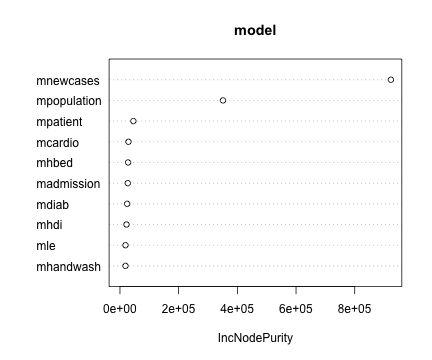

RObject{RealSxp}
            IncNodePurity
mnewcases       923303.18
mpopulation     351087.53
mcardio          29022.75
mdiab            24528.09
mhandwash        18836.88
mhbed            27687.74
mpatient         45648.85
madmission       26624.62
mhdi             22279.38
mle              18852.66


In [8]:
R"varImpPlot(model)"

### Create model per country using Distributed approach

In [9]:
@rput df
dfcw = R"""
library(tidyverse)
library(mice)
library(lubridate)

dfcm = df %>% group_by(location,week=week(date)) %>% 
summarise(
   mnewcases = mean(new_cases,na.rm=T),
   mnewdeaths = mean(new_deaths,na.rm=T),
   mpopulation = mean(population,na.rm=T),
   mcardio = mean(cardiovasc_death_rate,na.rm=T),
   mdiab = mean(diabetes_prevalence,na.rm=T),
   mhandwash = mean(handwashing_facilities,na.rm=T),
   mhbed = mean(hospital_beds_per_thousand,na.rm=T),
   mpatient = mean(hosp_patients,na.rm=T),
   madmission = mean(weekly_hosp_admissions,na.rm=T),
   mhdi = mean(human_development_index,na.rm=T),
   mle = mean(life_expectancy,na.rm=T)
) 
imp = mice(dfcm,method="sample")
complete(imp)
"""  |> rcopy

┌ Warning: RCall.jl: 
│ Attaching package: ‘lubridate’
│ 
│ The following objects are masked from ‘package:base’:
│ 
│     date, intersect, setdiff, union
│ 
└ @ RCall /Users/ppalmes/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: `summarise()` regrouping output by 'location' (override with `.groups` argument)
└ @ RCall /Users/ppalmes/.julia/packages/RCall/eRsxl/src/io.jl:160



 iter imp variable
  1   1  mnewcases  mnewdeaths  mcardio  mdiab  mhandwash  mhbed  mpatient  madmission  mhdi  mle
  1   2  mnewcases  mnewdeaths  mcardio  mdiab  mhandwash  mhbed  mpatient  madmission  mhdi  mle
  1   3  mnewcases  mnewdeaths  mcardio  mdiab  mhandwash  mhbed  mpatient  madmission  mhdi  mle
  1   4  mnewcases  mnewdeaths  mcardio  mdiab  mhandwash  mhbed  mpatient  madmission  mhdi  mle
  1   5  mnewcases  mnewdeaths  mcardio  mdiab  mhandwash  mhbed  mpatient  madmission  mhdi  mle
  2   1  mnewcases  mnewdeaths  mcardio  mdiab  mhandwash  mhbed  mpatient  madmission  mhdi  mle
  2   2  mnewcases  mnewdeaths  mcardio  mdiab  mhandwash  mhbed  mpatient  madmission  mhdi  mle
  2   3  mnewcases  mnewdeaths  mcardio  mdiab  mhandwash  mhbed  mpatient  madmission  mhdi  mle
  2   4  mnewcases  mnewdeaths  mcardio  mdiab  mhandwash  mhbed  mpatient  madmission  mhdi  mle
  2   5  mnewcases  mnewdeaths  mcardio  mdiab  mhandwash  mhbed  mpatient  madmission  mhdi  mle


┌ Warning: RCall.jl: Warning: Number of logged events: 1
└ @ RCall /Users/ppalmes/.julia/packages/RCall/eRsxl/src/io.jl:160


,location,week,mnewcases,mnewdeaths,mpopulation,mcardio,mdiab,mhandwash,mhbed,mpatient,madmission,mhdi,mle
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Afghanistan,4.0,0.0,0.0,3.89283e7,597.029,9.59,37.746,0.5,16.0,14.018,0.498,64.83
2,Afghanistan,5.0,0.0,0.0,3.89283e7,597.029,9.59,37.746,0.5,22.2857,4000.51,0.498,64.83
3,Afghanistan,6.0,0.0,0.0,3.89283e7,597.029,9.59,37.746,0.5,245.571,2.997,0.498,64.83
4,Afghanistan,7.0,0.0,0.0,3.89283e7,597.029,9.59,37.746,0.5,310.0,6.0,0.498,64.83
5,Afghanistan,8.0,0.142857,0.0,3.89283e7,597.029,9.59,37.746,0.5,1378.29,24.031,0.498,64.83
6,Afghanistan,9.0,0.142857,0.0,3.89283e7,597.029,9.59,37.746,0.5,11.0,8682.15,0.498,64.83
7,Afghanistan,10.0,0.857143,0.0,3.89283e7,597.029,9.59,37.746,0.5,55.3333,46641.4,0.498,64.83
8,Afghanistan,11.0,1.71429,0.0,3.89283e7,597.029,9.59,37.746,0.5,4324.29,58.497,0.498,64.83
9,Afghanistan,12.0,3.28571,0.142857,3.89283e7,597.029,9.59,37.746,0.5,160.571,151.81,0.498,64.83


In [10]:
describe(dfcw)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,location,,Afghanistan,,Zimbabwe,190,,String
2,week,26.9864,1.0,27.0,50.0,,,Float64
3,mnewcases,1207.57,0.0,19.8571,2.14704e5,,,Float64
4,mnewdeaths,26.4445,0.0,0.285714,2366.0,,,Float64
5,mpopulation,4.0954e7,809.0,9.44932e6,1.43932e9,,,Float64
6,mcardio,262.702,79.37,244.661,724.417,,,Float64
7,mdiab,7.90095,0.99,7.11,30.53,,,Float64
8,mhandwash,50.419,1.188,49.542,98.999,,,Float64
9,mhbed,2.99636,0.1,2.397,13.8,,,Float64


In [11]:
using Distributed
nprocs() == 1 && addprocs(;exeflags="--project")
@everywhere using RCall
@everywhere using DataFrames
@everywhere using DataFramesMeta

In [12]:
gmodels = Dict()
for subgp in groupby(dfcw,[:location])
    x = subgp[:,Not([:location,:week])]
    @async gmodels[subgp.location[1]]=R"randomForest(mnewcases ~ .,data=$x)"
end

┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall /Users/ppalmes/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall /Users/ppalmes/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall /Users/ppalmes/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer unique values.  Are you sure you want to do regression?
└ @ RCall /Users/ppalmes/.julia/packages/RCall/eRsxl/src/io.jl:160
┌ Warning: RCall.jl: Warning in randomForest.default(m, y, ...) :
│   The response has five or fewer uni

In [13]:
gmodels["Spain"]

RObject{VecSxp}

Call:
 randomForest(formula = mnewcases ~ ., data = `#JL`$x) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 3

          Mean of squared residuals: 12388172
                    % Var explained: 61.25


In [14]:
locations = unique(dfcw.location)

dmodels=@distributed for loc in locations
   println("processing:",loc)
   R"library(randomForest)"
   subgp = @where(dfcw,:location .== loc)
   xd = subgp[:,Not([:location,:week])]
   R"""
     model=randomForest(mnewcases ~ .,data=$xd)
     save(model,file=paste0($loc,".model"))
    """
end

Task (runnable) @0x000000011fa08b50

In [17]:
;ls

Afghanistan.model
Albania.model
Algeria.model
Andorra.model
Angola.model
Antigua and Barbuda.model
Argentina.model
Armenia.model
Australia.model
Austria.model
Azerbaijan.model
Bahamas.model
Bahrain.model
Bangladesh.model
Barbados.model
Belarus.model
Belgium.model
Belize.model
Benin.model
Bhutan.model
Bolivia.model
Bosnia and Herzegovina.model
Botswana.model
Brazil.model
Brunei.model
Bulgaria.model
Burkina Faso.model
Burundi.model
Cambodia.model
Cameroon.model
Canada.model
Cape Verde.model
Central African Republic.model
Chad.model
Chile.model
China.model
Colombia.model
Comoros.model
Congo.model
Costa Rica.model
Cote d'Ivoire.model
Croatia.model
Cuba.model
Cyprus.model
Czechia.model
Democratic Republic of Congo.model
Denmark.model
Djibouti.model
Dominica.model
Dominican Republic.model
Ecuador.model
Egypt.model
El Salvador.model
Equatorial Guinea.model
Eritrea.model
Estonia.model
Eswatini.model
Ethiopia.model
Expore-Covid-Data.ipynb
Fiji.model
Finland.model
France.model
Gabon.model
Gambia

In [18]:
R"load('Spain.model');model" 

RObject{VecSxp}

Call:
 randomForest(formula = mnewcases ~ ., data = `#JL`$xd) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 3

          Mean of squared residuals: 12779222
                    % Var explained: 60.02
